In [2]:
%matplotlib inline
%pylab inline

from functools import partial
import  matplotlib.pyplot as plt

import menpo.io as mio
from menpo.feature import imgfeature, fast_dsift
from menpo.landmark import labeller, ibug_face_68_trimesh
from menpo.visualize import visualize_images, print_dynamic, plot_graph
from menpo.visualize.viewmatplotlib import sample_colours_from_colourmap

from menpofit.result import compute_normalise_point_to_point_error, compute_cumulative_error
from menpofit.aam import (
    HolisticAAM, LucasKanadeAAMFitter, 
    holistic_sampling_from_scale,  holistic_sampling_from_step)
from menpofit.aam.algorithm.lk_alabort_arxiv2015 import (
    ProjectOutForwardGaussNewton, 
    ProjectOutInverseGaussNewton,
    ProjectOutAsymmetricGaussNewton,
    ProjectOutBidirectionalGaussNewtonCombined,
    ProjectOutBidirectionalGaussNewtonSimultaneous,
    ProjectOutBidirectionalGaussNewtonAlternated)
from menpofit.visualize import visualize_fitting_result, plot_ced, print_progress

Populating the interactive namespace from numpy and matplotlib


:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [2]:
@imgfeature
def fast_dsift2(image):
    if image.n_channels == 3:
        image = image.as_greyscale(mode='average')
    return fast_dsift(image)

## Load AAM

In [3]:
aam = mio.import_pickle('/Users/joan/PhD/Results/alabort_aam_2015/aam.pkl.gz')

## Load test data

In [4]:
test_images = []
for i in mio.import_images('/Users/joan/PhD/DataBases/faces/lfpw/testset/', 
                           verbose=True, max_images=None):    
    i = i.rescale_landmarks_to_diagonal_range(200)
    i = i.crop_to_landmarks_proportion(0.5)
    labeller(i, 'PTS', ibug_face_68_trimesh)
    if i.n_channels == 3:
        test_images.append(i)

Importing assets: [==========] 100% (224/224) - done.                           


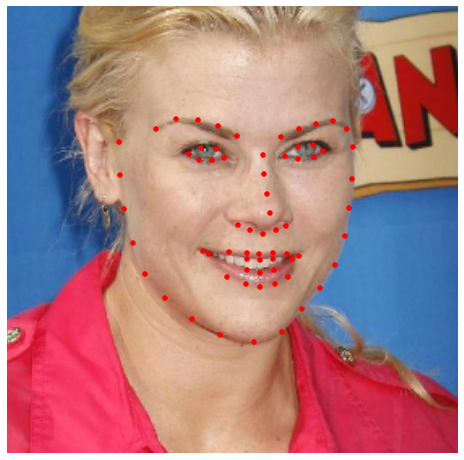

In [5]:
visualize_images(test_images)

## Fit AAM

In [6]:
n_shape = [3, 12]
n_appearance = 0.75
l = 0.5
max_iters = [24, 16]

#### Sampled AAM Fitters

In [7]:
sampling_scales = [0.125, 0.25, 0.5, 1.0]

fitters = []
for scale in sampling_scales:
    
    sampling_step_1, _ = holistic_sampling_from_scale(aam.appearance_models[0].mean(), 
                                                      scale=np.minimum(2 * scale, 1))
    sampling_step_2, _ = holistic_sampling_from_scale(aam.appearance_models[1].mean(), scale=scale)
    
    sampling_step = [sampling_step_1, sampling_step_2]

    fitter = LucasKanadeAAMFitter(
        aam, 
        lk_algorithm_cls=partial(ProjectOutAsymmetricGaussNewton), 
        n_shape=n_shape, 
        n_appearance=n_appearance,
        sampling=sampling_step)
    
    fitters.append(fitter)

In [112]:
n_fitters = len(fitters)
legend_entries = ['Initialization'] + ['{:.0f}%'.format(100*scale) for scale in sampling_scales]

#### Fitting loop, noise = 0

In [9]:
fitters_results_0 = []
for j, image in enumerate(test_images):
    
    np.random.seed(j)
    
    gt_shape = image.landmarks['ibug_face_68_trimesh'].lms
    initial_shape = fitters[0].noisy_shape_from_shape(gt_shape, noise_percentage=0.0)

    for fitter in fitters:
        
        fr = fitter.fit_from_shape(image, initial_shape, gt_shape=gt_shape, max_iters=max_iters) 
        fr.downscale = 0.5
        fitters_results_0.append(fr)
    
        print_dynamic(
            'Image: {} - Initial error: {} - Final error: {}'
            .format(j, fr.initial_error(), fr.final_error()))

#### Fitting loop, noise = 0.02

In [10]:
fitters_results_1 = []
for j, image in enumerate(test_images):
    
    np.random.seed(j)
    
    gt_shape = image.landmarks['ibug_face_68_trimesh'].lms
    initial_shape = fitters[0].noisy_shape_from_shape(gt_shape, noise_percentage=0.02)

    for fitter in fitters:
        
        fr = fitter.fit_from_shape(image, initial_shape, gt_shape=gt_shape, max_iters=max_iters) 
        fr.downscale = 0.5
        fitters_results_1.append(fr)
    
        print_dynamic(
            'Image: {} - Initial error: {} - Final error: {}'
            .format(j, fr.initial_error(), fr.final_error()))

#### Fitting loop, noise = 0.04

In [11]:
fitters_results_2 = []
for j, image in enumerate(test_images):
    
    np.random.seed(j)
    
    gt_shape = image.landmarks['ibug_face_68_trimesh'].lms
    initial_shape = fitters[0].noisy_shape_from_shape(gt_shape, noise_percentage=0.04)

    for fitter in fitters:
        
        fr = fitter.fit_from_shape(image, initial_shape, gt_shape=gt_shape, max_iters=max_iters) 
        fr.downscale = 0.5
        fitters_results_2.append(fr)
    
        print_dynamic(
            'Image: {} - Initial error: {} - Final error: {}'
            .format(j, fr.initial_error(), fr.final_error()))

#### Fitting loop, noise = 0.06

In [12]:
fitters_results_3 = []
for j, image in enumerate(test_images):
    
    np.random.seed(j)
    
    gt_shape = image.landmarks['ibug_face_68_trimesh'].lms
    initial_shape = fitters[0].noisy_shape_from_shape(gt_shape, noise_percentage=0.06)

    for fitter in fitters:
        
        fr = fitter.fit_from_shape(image, initial_shape, gt_shape=gt_shape, max_iters=max_iters) 
        fr.downscale = 0.5
        fitters_results_3.append(fr)
    
        print_dynamic(
            'Image: {} - Initial error: {} - Final error: {}'
            .format(j, fr.initial_error(), fr.final_error()))

## Results

In [4]:
folder_name = '/Users/joan/PhD/Papers/alabort_arxiv2015_aam/experiments/noise_vs_sampling/po_asymmetric_gn/'

Save fitters results:

In [27]:
fitters_results = [fitters_results_0,
                   fitters_results_1,
                   fitters_results_2,
                   fitters_results_3]

In [ ]:
serializable_fitters_results =[]

for frs in fitters_results:
    serializable_frs = []
    for fr in print_progress(frs):
        serializable_frs.append(fr.as_serializableresult())
    serializable_fitters_results.append(serializable_frs)
    
mio.export_pickle(serializable_fitters_results, folder_name + 'po_asymmetric_gn.pkl.gz')

In [25]:
# fitters_results = mio.import_pickle(folder_name + 'po_asymmetric_gn.pkl.gz')

# sampling_scales = [0.125, 0.25, 0.5, 1.0]
# n_fitters = len(fitters_results)
# legend_entries = ['Initialization'] + ['{:.0f}%'.format(100*scale) for scale in sampling_scales]
# max_iters = [24, 16]

Produce combind mean error vs standard deviation graph:

In [13]:
mean_errors = []
std_errors = []
median_errors = []

for frs in fitters_results:

    errors = []
    for j in range(n_fitters):
        errors_j = []
        for fr in frs[j::n_fitters]:
            error = compute_normalise_point_to_point_error(fr.final_shape.points[17:, :], 
                                                           fr.gt_shape.points[17:, :],
                                                           norm_shape=fr.gt_shape.points)
            errors_j.append(error)
        errors.append(errors_j)

    mean_errs = []
    std_errs = []
    median_errs = []
    for j in range(n_fitters):
        errs = np.asarray(errors[j])
        mean_errs.append(np.mean(errs))
        std_errs.append(np.std(errs))
        median_errs.append(np.median(errs))
    
    mean_errors.append(mean_errs)
    std_errors.append(std_errs)
    median_errors.append(median_errs)
    
mean_errors_matrix = np.asarray(mean_errors).T
std_errors_matrix = np.asarray(std_errors).T
median_errors_matrix = np.asarray(median_errors).T

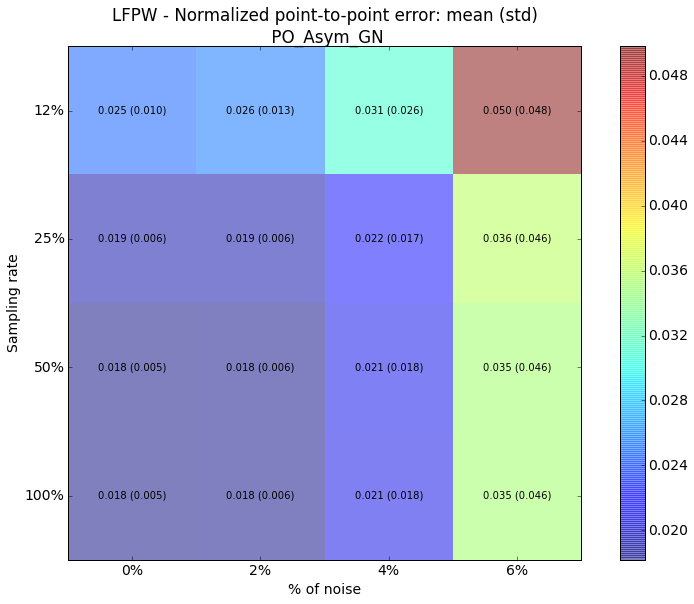

In [14]:
fig = plt.figure()
plt.clf()
ax = fig.add_subplot(111)
ax.set_aspect(1)
res = ax.imshow(np.array(mean_errors_matrix), cmap=plt.cm.jet, 
                alpha=0.5, interpolation='nearest')

height, width = mean_errors_matrix.shape



for x in xrange(width):
    for y in xrange(height):
        ax.annotate("{:.3f} ({:.3f})".format(mean_errors_matrix[x][y], std_errors_matrix[x][y]), xy=(y, x), 
                    horizontalalignment='center',
                    verticalalignment='center')

cb = fig.colorbar(res)
x_axis_labels = ['0%', '2%', '4%', '6%']
y_axis_labels = ['12%', '25%', '50%', '100%']
plt.xticks(range(width), x_axis_labels[:width])
plt.yticks(range(height), y_axis_labels[:height])
plt.xlabel('% of noise')
plt.ylabel('Sampling rate')

plt.title('LFPW - Normalized point-to-point error: mean (std)\n PO_Asym_GN')

plt.rcParams.update({'font.size': 14})

fig.set_size_inches(2.3 * fig.get_size_inches())

plt.savefig(folder_name + 'noise_vs_sampling_po_asymmetric.png', 
            format='png', dpi=300, bbox_inches='tight')

Measure the speed of each fitter:

In [ ]:
%timeit -n 10 fr = fitters[0].fit_from_shape(image, initial_shape, gt_shape=gt_shape, max_iters=max_iters) 
%timeit -n 10 fr = fitters[1].fit_from_shape(image, initial_shape, gt_shape=gt_shape, max_iters=max_iters) 
%timeit -n 10 fr = fitters[2].fit_from_shape(image, initial_shape, gt_shape=gt_shape, max_iters=max_iters) 
%timeit -n 10 fr = fitters[3].fit_from_shape(image, initial_shape, gt_shape=gt_shape, max_iters=max_iters) 

10 loops, best of 3: 386 ms per loop
10 loops, best of 3: 435 ms per loop
10 loops, best of 3: 683 ms per loop

For a particular level of noise: 

1) visualize fitting results:

In [18]:
noise = 0.04

if noise == 0:
    fitters_results = fitters_results[0]
elif noise == 0.02:
    fitters_results = fitters_results[1]
elif noise == 0.04:
    fitters_results = fitters_results[2]
elif noise == 0.06:
    fitters_results = fitters_results[3]

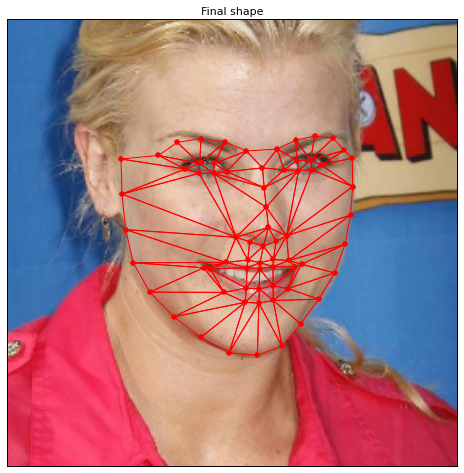

In [19]:
visualize_fitting_result(fitters_results)

2) Produce CED graph:

In [20]:
errors = [[]]
for fr in fitters_results[::n_fitters]:
    error = compute_normalise_point_to_point_error(fr.initial_shape.points[17:, :], 
                                                   fr.gt_shape.points[17:, :],
                                                   norm_shape=fr.gt_shape.points)
    errors[0].append(error)

for j in range(n_fitters):
    errors_j = []
    for fr in fitters_results[j::n_fitters]:
        error = compute_normalise_point_to_point_error(fr.final_shape.points[17:, :], 
                                                       fr.gt_shape.points[17:, :],
                                                       norm_shape=fr.gt_shape.points)
        errors_j.append(error)
    errors.append(errors_j)

In [21]:
x_axis =  np.arange(0, 0.065, 0.005)

cumulative_errors = []
for err in errors:
    cumulative_errors.append(compute_cumulative_error(err, x_axis))

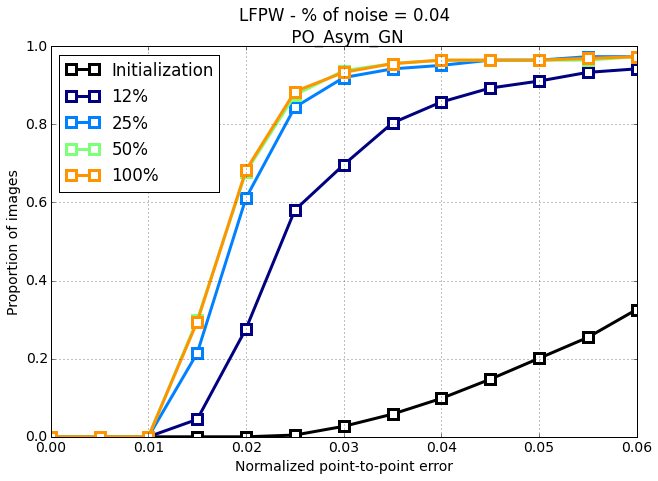

In [22]:
colours = ['black'] + sample_colours_from_colourmap(len(errors)-1, 'jet')

fig = plt.figure()
plt.hold(True)


for i in range(len(errors)):
    plt.plot(x_axis,
             cumulative_errors[i],
             color=colours[i],
             linewidth=3,
             marker='s',
             mec=colours[i],
             mfc='w',
             markersize=10,
             mew=3)
    
plt.xlabel('Normalized point-to-point error',)
plt.ylabel('Proportion of images')
plt.xlim((x_axis[0], x_axis[-1]))
plt.ylim((0, 1))
plt.legend(legend_entries, loc=2)
plt.grid(True)

plt.title('LFPW - % of noise = {0:.2f}\n PO_Asym_GN'.format(noise))

plt.rcParams.update({'font.size': 14})

fig.set_size_inches(1.75 * fig.get_size_inches())

plt.savefig(folder_name + 'ced_po_asymmetric_gn_{}.png'.format(int(100*noise)), 
            format='png', dpi=300, bbox_inches='tight')

3) Produce fitting statistics:

In [23]:
e = errors[0]
print legend_entries[0], '\t\tmean:{0:.4f}'.format(np.mean(e)), '\tstd:{0:.4f}'.format(np.std(e)), '\tmedian:{0:.4f}'.format(np.median(e)) 

for j, e in enumerate(errors[1:]):
    print legend_entries[j+1], '\t\tmean:{0:.4f}'.format(np.mean(e)), '\tstd:{0:.4f}'.format(np.std(e)), '\tmedian:{0:.4f}'.format(np.median(e))

Initialization 		mean:0.0735 	std:0.0264 	median:0.0718
12% 		mean:0.0309 	std:0.0257 	median:0.0235
25% 		mean:0.0222 	std:0.0174 	median:0.0186
50% 		mean:0.0212 	std:0.0180 	median:0.0174
100% 		mean:0.0211 	std:0.0179 	median:0.0173


4) Produce mean and median error convergence graphs:

In [27]:
mean_errors = []
std_errors = []
median_errors = []
for j in range(n_fitters):
    errors = []
    for fr in fitters_results[j::n_fitters]:
        errs = []
        for shape in fr.shapes:
            err = compute_normalise_point_to_point_error(shape.points[17:, :], 
                                                         fr.gt_shape.points[17:, :],
                                                         norm_shape=fr.gt_shape.points)            
            errs.append(err)
        while len(errs) < np.sum(max_iters) + 2:
            errs.append(errs[-1])
        errors.append(errs)
    mean_errors.append(np.mean(errors, axis=0))
    std_errors.append(np.std(errors, axis=0))
    median_errors.append(np.median(errors, axis=0))

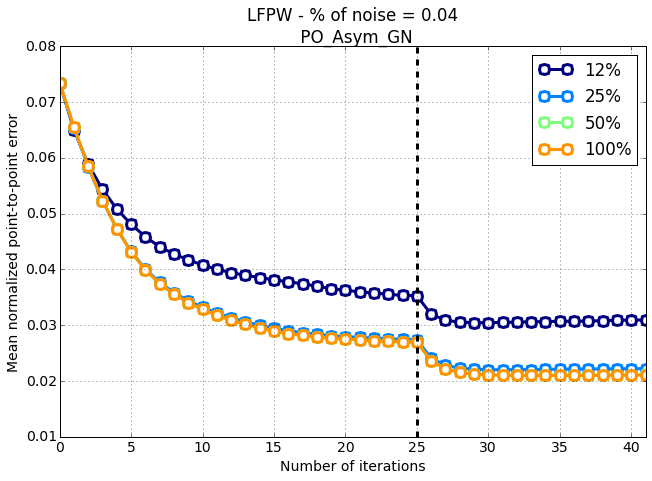

In [28]:
colours = sample_colours_from_colourmap(n_fitters, 'jet')

fig = plt.figure()
plt.hold(True)

for i in range(len(mean_errors)):
    plt.plot(np.arange(0, len(mean_errors[i])),
             mean_errors[i],
             color=colours[i],
             linewidth=3,
             marker='o',
             mec=colours[i],
             mfc='w',
             markersize=10,
             mew=3)
    
plt.xlabel('Number of iterations')
plt.ylabel('Mean normalized point-to-point error')
plt.xlim((0, len(mean_errors[i]) - 1))
plt.ylim((0.01, 0.08))
plt.legend(legend_entries[1:])
plt.grid(True)

xs = (max_iters[0] + 1 , max_iters[0] + 1)
ys = (0.01, 0.08)
plt.plot(xs, ys, 'k--', lw=3)

plt.title('LFPW - % of noise = {0:.2f}\n PO_Asym_GN'.format(noise))

plt.rcParams.update({'font.size': 14})

fig.set_size_inches(1.75 * fig.get_size_inches())

plt.savefig(folder_name + 'mean_error_vs_iters_po_asymmetric_gn_{}.png'.format(int(100*noise)), 
            format='png', dpi=300, bbox_inches='tight')

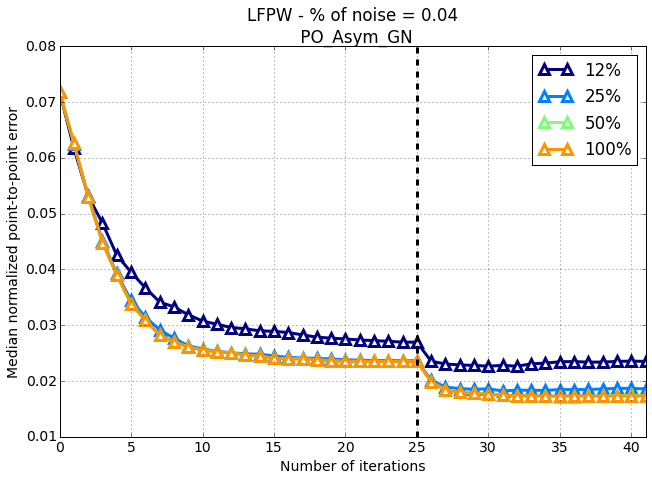

In [29]:
colours = sample_colours_from_colourmap(n_fitters, 'jet')

fig = plt.figure()
plt.hold(True)

for i in range(len(mean_errors)):
    plt.plot(np.arange(0, len(mean_errors[i])),
             median_errors[i],
             color=colours[i],
             linewidth=3,
             marker='^',
             mec=colours[i],
             mfc='w',
             markersize=10,
             mew=3)


    
plt.xlabel('Number of iterations')
plt.ylabel('Median normalized point-to-point error')
plt.xlim((0, len(mean_errors[i]) - 1))
plt.ylim((0.01, 0.08))
plt.legend(legend_entries[1:])
plt.grid(True)

plt.title('LFPW - % of noise = {0:.2f}\n PO_Asym_GN'.format(noise))

plt.rcParams.update({'font.size': 14})

xs = (max_iters[0] + 1 , max_iters[0] + 1)
ys = (0.01, 0.08)
plt.plot(xs, ys, 'k--', lw=3)

fig.set_size_inches(1.75 * fig.get_size_inches())

plt.savefig(folder_name + 'median_error_vs_iters_po_asymmetric_gn_{}.png'.format(int(100*noise)), 
            format='png', dpi=300,  bbox_inches='tight')

## Other

In [24]:
# colours = sample_colours_from_colourmap(n_fitters, 'jet')

# fig = plt.figure()
# plt.hold(True)

# for i in range(len(mean_errors)):
#     plt.errorbar(np.arange(0, len(mean_errors[i])), 
#                  mean_errors[i], 
#                  yerr=0.1 * std_errors[i],
#                  color=colours[i],
#                  marker='o',
#                  markersize=10,
#                  linewidth=1.5)
#     plt.fill_between(np.arange(0, len(mean_errors[i])), 
#                      mean_errors[i] - 0.1 * std_errors[i], 
#                      mean_errors[i] + 0.1 * std_errors[i],
#                      color=colours[i],
#                      alpha=0.1)
#     plt.plot(np.arange(0, len(mean_errors[i])),
#              median_errors[i],
#              '--',
#              color=colours[i],
#              marker='^',
#              markersize=10,
#              linewidth=1,
#              alpha=0.75)
    
# plt.xlabel('Normalized point-to-point error')
# plt.ylabel('Number of iterations')
# plt.xlim((0, len(mean_errors[i]) - 1))
# plt.legend(['12.5%', '12.5%', 
#             '25%', '25%', 
#             '50%', '50%', 
#             '100%', '100%',  ])

# fig.set_size_inches(1.5*fig.get_size_inches())

In [25]:
# import line_profiler
# import IPython

# ip = IPython.get_ipython()
# ip.define_magic('lprun', line_profiler.magic_lprun)

In [26]:
# %lprun -f ProjectOutAsymmetricGaussNewton._solve fitter_3.fit_from_shape(i, s, gt_shape=gt_s, max_iters=2) 